In [0]:
from glob import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import shutil
from torchvision import transforms
from torchvision import models
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch.optim import lr_scheduler
from torch import optim
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import time
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import *
from sklearn.metrics import classification_report
import statistics
import itertools
np.set_printoptions(threshold=np.inf)
from PIL import Image  
import PIL
import copy
from torchsummary import summary
from torch import topk
import skimage.transform

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
simple_transform = transforms.Compose([transforms.Resize((112,112),interpolation=3),
                                       transforms.ToTensor()])

In [0]:
train = ImageFolder('/content/drive/My Drive/Alvaro Train/',simple_transform)
test = ImageFolder('/content/drive/My Drive/Alvaro Test/',simple_transform)

In [0]:
use_cuda = torch.cuda.is_available()
torch.manual_seed(1)
np.random.seed(5)
classes_list = list(train.class_to_idx.keys())
device = torch.device("cuda" if use_cuda else "cpu")
epochs = 50
batch_size = 64
n_classes = 20
n_iterations = 5
ratio = 0.2

In [0]:
targets = train.targets
train_idx, valid_idx= train_test_split(np.arange(len(targets)),test_size=ratio,shuffle=True,stratify=targets)
train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
valid_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)

trainloader = torch.utils.data.DataLoader(train, batch_size=64, sampler=train_sampler,num_workers=2)
valloader = torch.utils.data.DataLoader(train, batch_size=64, sampler=valid_sampler,num_workers=2)
testloader = torch.utils.data.DataLoader(test, batch_size=64, shuffle=True, num_workers=2)

In [0]:
train_examples = int((1.0-ratio)*len(train))
val_examples = int(ratio*len(train))
train_dataset, val_dataset = torch.utils.data.dataset.random_split(train,[train_examples,val_examples])
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_dataset,batch_size=64,shuffle=True,num_workers=2)
testloader = torch.utils.data.DataLoader(test, batch_size=64, shuffle=True, num_workers=2)

In [0]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1, 1, bias=False)
        self.conv1_bn = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, 1, 1, bias=False)
        self.conv2_bn = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, 1, 1, bias=False)
        self.conv4 = nn.Conv2d(128,256,3,1,1,bias=False)
        self.fc1 = nn.Linear(12544, 500)
        self.fc1_drop = nn.Dropout2d(p=0.5)
        self.fc2 = nn.Linear(500,256)
        self.fc2_drop = nn.Dropout2d(p=0.4)
        self.fc3 = nn.Linear(256,20)
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        x = F.leaky_relu(self.pool(self.conv1_bn(self.conv1(x))))
        x = F.leaky_relu(self.pool(self.conv2_bn(self.conv2(x))))
        x = F.leaky_relu(self.pool(self.conv3(x)))
        x = F.leaky_relu(self.pool(self.conv4(x)))
        x = x.view(x.size(0),-1)
        x = F.leaky_relu(self.fc1_drop(self.fc1(x)))
        x = F.leaky_relu(self.fc2_drop(self.fc2(x)))
        x = self.fc3(x)

        
        return F.log_softmax(x, dim=1)

In [0]:
class ClassifierGenerator(nn.Module):
    def __init__(self):
        super(ClassifierGenerator, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1, 1, bias=False)
        self.conv1_bn = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, 1, 1, bias=False)
        self.conv2_bn = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, 1, 1, bias=False)
        self.conv4 = nn.Conv2d(128,256,3,1,1,bias=False)
        self.fc1 = nn.Linear(12544, 500)
        self.fc1_drop = nn.Dropout2d(p=0.5)
        self.fc2 = nn.Linear(500,256)
        self.fc2_drop = nn.Dropout2d(p=0.4)
        self.fc3 = nn.Linear(256,20)
        self.pool = nn.MaxPool2d(2)
        #model = models.resnet34(pretrained=True)
        #model = Classifier().cuda()
        #name = "alvaro_model1_classier_plain.pth"
        #for param in model.parameters():
          #param.requires_grad = False
        #num_features = model.fc.in_features
        #model.fc = nn.Linear(num_features,20)
        #name = "alvaro_resnet.pth"
        #model = model.cuda()
        #path = F"/content/drive/My Drive/Colab Notebooks/Alvaro/{name}"
        #model.load_state_dict(torch.load(path))
        #self.classifier = model

    def forward(self, x):
      gradcams = []
      for image in x:
        gradcam = generate_gradcam(image,model1,"conv4","fc3")
        gradcams.append(gradcam)
      x = F.leaky_relu(self.pool(self.conv1_bn(self.conv1(x))))
      x = F.leaky_relu(self.pool(self.conv2_bn(self.conv2(x))))
      x = F.leaky_relu(self.pool(self.conv3(x)))
      x = F.leaky_relu(self.pool(self.conv4(x)))
      x = x.view(x.size(0),-1)
      x = F.leaky_relu(self.fc1_drop(self.fc1(x)))
      x = F.leaky_relu(self.fc2_drop(self.fc2(x)))
      x = self.fc3(x)
      return gradcams, F.log_softmax(x, dim=1)

In [0]:
#code adapted from https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    #if normalize:
        #cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:0.0f}".format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [0]:
def plot_graph(training_losses,val_losses,epochs,string,mode):
    filename=""
    path = F"/content/drive/My Drive/Colab Notebooks/Graphs/{filename}"
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel(string)
    if mode=="plain":
      filename = "model1_" + string + "_.png" 
      plt.title(string + 'per epoch - ' + "Simple classifier")
    if mode=="mixed":
      filename = "model3_" + string + "_.png" 
      plt.title(string + 'per epoch - ' + "Mixed model")
    if mode=="subtractive":
      filename = "model4_" + string + "_.png" 
      plt.title(string + 'per epoch - ' + "Subtractive feedback")
    if mode=="subtractive pre":
      filename = "model5_" + string + "_.png" 
      plt.title(string + 'per epoch - ' + "Subtractive feedback using a pretrained classifier")
    if mode=="multiplicative":
      filename = "model6_" + string + "_.png" 
      plt.title(string + 'per epoch - ' + "Multiplicative feedback")
    if mode=="multiplicative pre":
      filename = "model7_" + string + "_.png" 
      plt.title(string + 'per epoch - ' + "Multiplicative feedback using a pretrained classifier")
    if mode=="plain genout":
      filename = "model8_" + string + "_.png" 
      plt.title(string + 'per epoch - ' + "Simple classifier using 6-channel image")
    if mode=="feedback genout":
      filename = "model9_" + string + "_.png" 
      plt.title(string + 'per epoch - ' + "Using gen output as a 2nd input channel")
    if mode=="feedback genout pre":
      filename = "model10_" + string + "_.png" 
      plt.title(string + "Using gen output as a 2nd input channel using a pretrained classifier")
    if mode=="gradcam fb":
      filename = "gradcam_" + string + "_.png"
      plt.title(string + "Using GradCAM") 
    
    plt.plot(range(epochs),training_losses,label="Training " + string)
    plt.plot(range(epochs),val_losses,label="Validation " + string)
    plt.legend()
    plt.savefig(path+filename)
    print(path+filename)

In [0]:
def accuracy_per_iteration(accuracies,mode):
  print(accuracies)
  filename = ""
  path = F"/content/drive/My Drive/Colab Notebooks/Graphs/{filename}"
  plt.rcParams["figure.figsize"] = (6,4)
  plt.figure()
  string = "_Acc per iteration.png"
  if mode=="subtractive":
      filename = "model4" + string
      plt.title("Accuracy per epoch " + "Subtractive feedback")
  if mode=="subtractive pre":
      filename = "model5" + string
      plt.title("Accuracy per epoch " + "Subtractive feedback with pretrained classifier")
  if mode=="multiplicative":
      filename = "model6" + string
      plt.title("Accuracy per epoch " + "Multiplicative feedback")
  if mode=="multiplicative pre":
      filename = "model7" + string
      plt.title("Accuracy per epoch " + "Multiplicative feedback with pretrained classifier")
  if mode=="genout feedback":
      filename = "model9" + string
      plt.title("Accuracy per epoch " + "Using gen out as a second input channel")
  if mode=="genout feedback pre":
      filename = "model10" + string
      plt.title("Accuracy per epoch " + "Using gen out as a second input channel with pretrained classifier")
  if mode=="gradcam fb":
      filename = "gradcam fb" + string
      plt.title("Accuracy per epoch " + "Using Class Activation Mappings")
  plt.plot(range(n_iterations),accuracies)
  plt.xticks(range(n_iterations))
  plt.xlabel("Iteration")
  plt.ylabel("Accuracy")
  plt.savefig(path+filename)
  print(path+filename)

In [0]:
def gradcams_batch(images):
  multiplied_batch = torch.Tensor(0,3,112,112)
  for image in images:
    gradcam = generate_gradcam(image,model1,"conv4","fc3")
    result = image.cpu()*gradcam
    result = result.unsqueeze(0)
    multiplied_batch = torch.cat((multiplied_batch,result),0)
    print(multiplied_batch.shape)
  return multiplied_batch

In [0]:
def multiplied_gradcams_batch(images,gradcams):
  multiplied_batch = torch.Tensor(0,3,112,112)
  for image, gradcam in zip(images,gradcams):
    result = image.cpu()*gradcam
    result = result.unsqueeze(0)
    multiplied_batch = torch.cat((multiplied_batch,result),0)
  return multiplied_batch

In [0]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = ((output.cpu()).data).numpy()
    def remove(self): self.hook.remove()

In [0]:
def train_validate(model,optimizer,criterion,mode):
  current = time.time()
  criterion1 = nn.MSELoss()
  model = model.cuda()
  best_model = model
  best_accuracy = 0
  stats = []
  training_losses = []
  val_losses = []
  train_accuracies = []
  val_accuracies = []
  for epoch in range(epochs):
    #train
      print("Epoch", epoch)
      model.train()
      train_epoch_loss = 0
      train_correct = 0
      for index, (images,labels) in enumerate(trainloader):
          images, labels = images.cuda(), labels.cuda()
          optimizer.zero_grad()
          if mode=="plain":
            predicted = model(images)
            loss = criterion(predicted,labels)
            loss.backward()
            train_epoch_loss += loss.item()

          elif mode=="gradcam":
            #if epoch==0:
              #for image in images:
                #gradcam = generate_gradcam(image,model1,"conv4","fc3")
                #result = image.cpu()*gradcam
                #result = result.unsqeeze(0)
                #results = torch.cat((results,result),0)
            results = gradcams_batch(images)
            predicted = model(results.cuda())
            loss = criterion(predicted,labels)
            loss.backward()
            train_epoch_loss += loss.item()

          elif mode=="gradcam fb":
            gradcams, predicted = model(images)
            results = multiplied_gradcams_batch(images,gradcams)
            for i in range(n_iterations):
              gradcams, predicted = model(results.cuda())
              results = multiplied_gradcams_batch(images,gradcams)
            loss = criterion(predicted,labels)
            loss.backward()
            train_epoch_loss += loss.item()
          
          elif mode=="plain genout":
            torch_zeros = torch.zeros(images.shape[0],3,112,112).cuda()
            stacked_images = torch.cat((images,torch_zeros),1)
            predicted = model(stacked_images)
            loss = criterion(predicted,labels)
            loss.backward()
            train_epoch_loss += loss.item()
            
          elif mode=="mixed":
            decoded, predicted = model(images)
            loss1 = (criterion1(decoded,images)-0.004711)/0.0073023
            loss2 = (criterion(predicted,labels)-0.182464)/0.418885
            #loss1 = criterion1(decoded,images)
            #loss2 = criterion(predicted,labels)
            train_loss = loss1+loss2
            train_loss.backward()
            train_epoch_loss += train_loss.item()

          elif mode=="subtractive" or mode=="multiplicative":
            generated, predicted = model(images)
            alpha = 0.1
            for i in range(n_iterations):
              if mode=="subtractive":
                generated, predicted = model(images-generated*alpha)
              elif mode=="multiplicative":
                generated, predicted = model(images*generated*alpha)
              alpha = alpha + 0.1
            loss1 = criterion1(generated,images) 
            loss2 = criterion(predicted,labels)
            loss = loss1+loss2
            loss.backward()
            train_epoch_loss += loss.item()

          elif mode=="genout feedback":
            torch_zeros = torch.zeros(images.shape[0],3,112,112).cuda()
            stacked_images = torch.cat((images,torch_zeros),1)
            total_loss = 0
            for i in range(n_iterations):
              generated, predicted = model(stacked_images)
              stacked_images = torch.cat((images,generated),1)
            loss1 = criterion1(generated,images)
            loss2 = criterion(predicted,labels)
            loss = loss2
            loss.backward()
            train_epoch_loss += loss.item()


          optimizer.step()
          pred = predicted.max(1,keepdim=True)[1] # get the index of the max log-probability
          train_correct += pred.eq(labels.view_as(pred)).sum().item()
          
      train_epoch_loss /= len(trainloader)
      print('Average training loss: {:.4f}, Training Accuracy: {}/{} ({:.0f}%)'.format(
          train_epoch_loss, train_correct, len(train_idx),
          100. * train_correct / len(train_idx)))
      training_losses.append(train_epoch_loss)
      train_accuracies.append(100. * train_correct / len(train_idx))

      
    #validate
      model.eval()
      val_epoch_loss = 0
      val_correct = 0
      with torch.no_grad():
          for index,(images, labels) in enumerate(valloader):
              images, labels = images.cuda(), labels.cuda()
              if mode=="plain":
                predicted = model(images)
                loss = criterion(predicted,labels)
                val_epoch_loss += loss.item()

              elif mode=="gradcam":
                results = gradcams_batch(images)
                predicted = model(results.cuda())
                loss = criterion(predicted,labels)
                val_epoch_loss += loss.item()


              elif mode=="gradcam fb":
                gradcams, predicted = model(images)
                results = multiplied_gradcams_batch(images,gradcams)
                for i in range(n_iterations):
                  gradcams, predicted = model(results.cuda())
                  results = multiplied_gradcams_batch(images,gradcams)
                loss = criterion(predicted,labels)
                val_epoch_loss += loss.item()

              elif mode=="plain genout":
                torch_zeros = torch.zeros(images.shape[0],3,112,112).cuda()
                stacked_images = torch.cat((images,torch_zeros),1)
                predicted = model(stacked_images)
                loss = criterion(predicted,labels)
                val_epoch_loss += loss.item()
              
              elif mode=="mixed":
                decoded, predicted = model(images)
                criterion1 = nn.MSELoss()
                loss1 = (criterion1(decoded,images)-0.003914)/0.002518
                loss2 = (criterion(predicted,labels)-0.211241)/0.3020565
                #loss1 = criterion1(decoded,images)
                #loss2 = criterion(predicted,labels)
                val_loss = loss1+loss2
                val_epoch_loss += val_loss.item()

            
              elif mode=="subtractive" or mode=="multiplicative":
                generated, predicted = model(images)
                alpha = 0.1
                total_loss = 0
                for i in range(n_iterations):
                  if mode=="subtractive":
                    generated, predicted = model(images-generated*alpha)
                  elif mode=="multiplicative":
                    generated, predicted = model(images*generated*alpha)
                  alpha = alpha + 0.1
                val_loss1 = criterion1(generated,images)
                val_loss2 = criterion(predicted,labels)
                val_loss = val_loss1+val_loss2
                val_epoch_loss += val_loss.item()

              elif mode=="genout feedback":
                torch_zeros = torch.zeros(images.shape[0],3,112,112).cuda()
                stacked_images = torch.cat((images,torch_zeros),1)
                total_loss = 0
                for i in range(n_iterations):
                  generated, predicted = model(stacked_images)
                  stacked_images = torch.cat((images,generated),1)
                val_loss1 = criterion1(generated,images)
                val_loss2 = criterion(predicted,labels)
                val_loss = val_loss2
                val_epoch_loss += val_loss.item()
  
              pred = predicted.max(1,keepdim=True)[1] # get the index of the max log-probability
              val_correct += pred.eq(labels.view_as(pred)).sum().item()
      
      val_epoch_loss /= len(valloader)
      print('Average validation loss: {:.4f}, Validation Accuracy: {}/{} ({:.0f}%)'.format(
          val_epoch_loss, val_correct, len(valid_idx),
          100. * val_correct / len(valid_idx)))
      val_losses.append(val_epoch_loss)
      val_accuracies.append(100. * val_correct / len(valid_idx))
      if (100. * val_correct / len(valid_idx) > best_accuracy):
        best_accuracy = 100. * val_correct / len(valid_idx)
        best_model = copy.deepcopy(model)

  end = time.time()
  diff = end - current
  print("Training took %d seconds"% (diff) )
  print("Lowest validation loss", min(val_losses))
  print("Lowest training loss", min(training_losses))
  print("Highest training accuracy",max(train_accuracies))
  print("Highest validation accuracy",max(val_accuracies))
  stats.append(training_losses)
  stats.append(train_accuracies)
  stats.append(val_losses)
  stats.append(val_accuracies)
  return best_model, stats

In [0]:
def getCAM(feature_conv, weight_fc, class_idx):
    _, nc, h, w = feature_conv.shape
    cam = weight_fc[class_idx].dot(feature_conv.reshape((nc, h*w)))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    return [cam_img]

In [0]:
preprocess = transforms.Compose([
   transforms.ToTensor(),
])

def generate_gradcam(image,model,conv,fc):
  img = transforms.ToPILImage()(image.cpu())
  tensor = preprocess(img)
  prediction_var = Variable((tensor.unsqueeze(0)).cuda(), requires_grad=True)
  final_layer = model._modules.get(conv)
  activated_features = SaveFeatures(final_layer)
  if model==model1:
    prediction = model(prediction_var)
  else:
    _,prediction = model(prediction_var)
  pred_probabilities = F.softmax(prediction).data.squeeze()
  activated_features.remove()
  weight_softmax_params = list(model._modules.get(fc).parameters())
  weight_softmax = np.squeeze(weight_softmax_params[0].cpu().data.numpy())
  class_idx = topk(pred_probabilities,1)[1].int()
  overlay = getCAM(activated_features.features,weight_softmax,class_idx)
  gradcam = skimage.transform.resize(overlay[0],tensor.shape[1:3])
  return gradcam

In [0]:
#confusion matrix code adapted from https://stackoverflow.com/questions/53290306/confusion-matrix-and-test-accuracy-for-pytorch-transfer-learning-tutorial
def test_model(model,criterion,mode):
  model.eval()
  criterion1 = nn.MSELoss()
  test_epoch_loss = 0
  test_correct = 0
  best_accuracy = 0
  class_correct = list(0 for i in range(n_classes))
  class_total = list(0 for i in range(n_classes))
  mean_accuracies = list(0 for i in range(n_iterations))
  predlist=torch.zeros(0,dtype=torch.long, device='cpu')
  labelslist=torch.zeros(0,dtype=torch.long, device='cpu')

  with torch.no_grad():
      accuracies = [[] for i in range(n_iterations)]
      for index,(images, labels) in enumerate(testloader):
            images, labels = images.cuda(), labels.cuda()

            if mode=="plain":
              predicted = model(images)
              loss = criterion(predicted,labels)
              test_epoch_loss += loss.item()
              best_predicted = predicted

            elif mode=="gradcam":
              results = gradcams_batch(images)
              predicted = model(results.cuda())
              loss = criterion(predicted,labels)
              loss.backward()
              test_epoch_loss += loss.item()
              best_predicted = predicted

            elif mode=="gradcam fb":
              gradcams, predicted = model(images)
              results = multiplied_gradcams_batch(images,gradcams)
              for i in range(n_iterations):
                iteration_correct = 0
                gradcams, predicted = model(results.cuda())
                results = multiplied_gradcams_batch(images,gradcams)

                pred_it = predicted.max(1, keepdim=True)[1]
                iteration_correct += pred_it.eq(labels.view_as(pred_it)).sum().item()
                accuracies[i] = accuracies[i] + [100.*iteration_correct/len(images)]

                for j, el in enumerate(accuracies):
                  mean_accuracies[j] = sum(el)/len(testloader)
                  if mean_accuracies[j]>best_accuracy:
                    best_accuracy = mean_accuracies[j]
                    best_predicted = predicted

              loss = criterion(best_predicted,labels)
              test_epoch_loss += loss.item()

              
            
            elif mode=="plain genout":
              torch_zeros = torch.zeros(images.shape[0],3,112,112).cuda()
              stacked_images = torch.cat((images,torch_zeros),1)
              predicted = model(stacked_images)
              loss = criterion(predicted,labels)
              test_epoch_loss += loss.item()
            
            elif mode=="mixed":
              decoded, predicted = model(images)
              criterion1 = nn.MSELoss()
              loss1 = (criterion1(decoded,images)-0.003914)/0.002518
              loss2 = (criterion(predicted,labels)-0.211241)/0.3020565
              #loss1 = criterion1(decoded,images)
              #loss2 = criterion(predicted,labels)
              loss = loss1+loss2
              test_epoch_loss += loss.item()
              best_predicted = predicted

            elif mode=="subtractive" or mode=="multiplicative":
                best_predicted = 0
                criterion1 = nn.MSELoss()
                generated, predicted = model(images)
                alpha = 0.1
                for i in range(n_iterations):
                  iteration_correct = 0
                  if mode=="subtractive":
                    generated, predicted = model(images-generated*alpha)
                  elif mode=="multiplicative":
                    generated, predicted = model(images*generated*alpha)
                  alpha = alpha + 0.1
                

                  pred_it = predicted.max(1, keepdim=True)[1]
                  iteration_correct += pred_it.eq(labels.view_as(pred_it)).sum().item()
                  accuracies[i] = accuracies[i] + [100.*iteration_correct/len(images)]

                  for j, el in enumerate(accuracies):
                    mean_accuracies[j] = sum(el)/len(testloader)
                    if mean_accuracies[j]>best_accuracy:
                      best_accuracy = mean_accuracies[j]
                      best_predicted = predicted

                loss1 = criterion1(generated,images)
                loss2 = criterion(best_predicted,labels)
                loss = loss1+loss2
                test_epoch_loss += loss.item()

            elif mode=="genout feedback":
                torch_zeros = torch.zeros(images.shape[0],3,112,112).cuda()
                stacked_images = torch.cat((images,torch_zeros),1)
                for i in range(n_iterations):
                  iteration_correct = 0
                  generated, predicted = model(stacked_images)
                  stacked_images = torch.cat((images,generated),1)
                  

                  pred_it = predicted.max(1, keepdim=True)[1]
                  iteration_correct += pred_it.eq(labels.view_as(pred_it)).sum().item()
                  accuracies[i] = accuracies[i] + [100.*iteration_correct/len(images)]

                loss1 = criterion1(generated,images)
                loss2 = criterion(predicted,labels)
                loss = loss2
                test_epoch_loss += loss.item()

            _, predicted_l = torch.max(best_predicted.data, 1)
            test_correct += (predicted_l == labels).sum().item()
            c = (predicted_l == labels).squeeze()

            predlist=torch.cat([predlist,predicted_l.view(-1).cpu()])
            labelslist=torch.cat([labelslist,labels.view(-1).cpu()])

            for i in range(labels.size(0)):
              label = labels[i]
              class_correct[label] += c[i].item()
              class_total[label] += 1
  test_epoch_loss /= len(testloader)
  print('\nTest loss: {:.4f} \nTesting Accuracy: {}/{} ({:.0f}%)'.format(
      test_epoch_loss, test_correct, len(testloader.dataset),
        100. * test_correct / len(testloader.dataset)))
  for i in range(n_classes):
      print("{} Class Accuracy: {}/{} ({:.1f}%)".format(classes_list[i],class_correct[i],class_total[i],100*class_correct[i]/class_total[i]))

  precision = precision_score(predlist.numpy(), labelslist.numpy(), average='macro')
  recall = recall_score(predlist.numpy(), labelslist.numpy(), average='macro')
  accuracy = accuracy_score(predlist.numpy(), labelslist.numpy())
  f1 = fbeta_score(predlist.numpy(), labelslist.numpy(), 1, average='macro') #1 means f_1 measure
  print("Classifier has Acc=%0.3f P=%0.3f R=%0.3f F1=%0.3f" % (accuracy,precision,recall,f1))
  conf_matrix=confusion_matrix(labelslist.numpy(), predlist.numpy())
  plt.figure(figsize=(8, 8))
  plot_confusion(conf_matrix, classes_list,'Confusion matrix')
  print(classification_report(labelslist.numpy(), predlist.numpy(),target_names=classes_list))

  return mean_accuracies
  

In [18]:
model1 = Classifier().cuda()
name = "alvaro_model1_classier_plain.pth"
path = F"/content/drive/My Drive/Colab Notebooks/Alvaro/{name}"
model1.load_state_dict(torch.load(path))

<All keys matched successfully>

In [0]:
criterion = nn.CrossEntropyLoss()
accuracies_model1 = test_model(model1,criterion,"plain")


Test loss: 0.3020 
Testing Accuracy: 741/800 (93%)
bag Class Accuracy: 39/40 (97.5%)
beer Class Accuracy: 38/40 (95.0%)
book Class Accuracy: 36/40 (90.0%)
case Class Accuracy: 37/40 (92.5%)
coffee Class Accuracy: 38/40 (95.0%)
cup Class Accuracy: 36/40 (90.0%)
deodorant Class Accuracy: 38/40 (95.0%)
eraser Class Accuracy: 38/40 (95.0%)
hole Class Accuracy: 39/40 (97.5%)
mouse Class Accuracy: 33/40 (82.5%)
mug Class Accuracy: 34/40 (85.0%)
sleep Class Accuracy: 38/40 (95.0%)
speaker Class Accuracy: 33/40 (82.5%)
spray Class Accuracy: 38/40 (95.0%)
stapler Class Accuracy: 37/40 (92.5%)
tape Class Accuracy: 36/40 (90.0%)
tea Class Accuracy: 39/40 (97.5%)
tissues Class Accuracy: 40/40 (100.0%)
umbrella Class Accuracy: 36/40 (90.0%)
watch Class Accuracy: 38/40 (95.0%)
Classifier has Acc=0.926 P=0.926 R=0.932 F1=0.927


NameError: ignored

<Figure size 576x576 with 0 Axes>

In [0]:
test_images, labels = next(iter(testloader))

plt.rcParams["figure.figsize"] = (20,3)
for i in range(20):
  fig = plt.figure()
  plot = fig.add_subplot(1, 2, 1)
  plot.set_title('Original Image ')
  image = test_images[i].cpu()
  image_input = np.transpose(image.cpu(),(1,2,0))
  imgplot = plt.imshow(image_input)

  plot = fig.add_subplot(1,2,2)
  plot.set_title("GradCAM")
  plt.imshow(image_input)
  gradcam = generate_gradcam(test_images[i],model1,"conv4","fc3")
  plt.imshow(gradcam,alpha=0.4,cmap='jet')

  

In [0]:
plt.rcParams["figure.figsize"] = (20,3)
for i in range(20):
  fig = plt.figure()
  plot = fig.add_subplot(1, 3, 1)
  plot.set_title('Original Image ')
  image = test_images[i].cpu()
  image_input = np.transpose(image.cpu(),(1,2,0))
  imgplot = plt.imshow(image_input)
  plot = fig.add_subplot(1,3,2)
  plot.set_title("GradCAM")
  plt.imshow(image_input)
  gradcam = generate_gradcam(test_images[i],model1,"conv4","fc3")
  plt.imshow(gradcam,alpha=0.4,cmap='jet')
  plot = fig.add_subplot(1,3,3)
  plot.set_title("Difference")
  difference = np.transpose((image*gradcam),(1,2,0))
  plt.imshow(np.clip(difference,0,1))
  

In [0]:
#model4 = ClassifierGenerator().cuda()
model1 = Classifier().cuda()
optimizer = optim.Adam(model1.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss()
model1,model1_stats = train_validate(model1,optimizer,criterion,"gradcam")

Epoch 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


Average training loss: 2.7804, Training Accuracy: 396/3200 (12%)
Average validation loss: 3.0176, Validation Accuracy: 122/800 (15%)
Epoch 1
Average training loss: 1.8597, Training Accuracy: 1252/3200 (39%)
Average validation loss: 2.9232, Validation Accuracy: 237/800 (30%)
Epoch 2
Average training loss: 1.2958, Training Accuracy: 1844/3200 (58%)
Average validation loss: 1.9877, Validation Accuracy: 351/800 (44%)
Epoch 3
Average training loss: 0.8308, Training Accuracy: 2326/3200 (73%)
Average validation loss: 3.1933, Validation Accuracy: 288/800 (36%)
Epoch 4
Average training loss: 0.5773, Training Accuracy: 2606/3200 (81%)
Average validation loss: 1.8880, Validation Accuracy: 422/800 (53%)
Epoch 5
Average training loss: 0.3819, Training Accuracy: 2813/3200 (88%)
Average validation loss: 1.2151, Validation Accuracy: 521/800 (65%)
Epoch 6
Average training loss: 0.3126, Training Accuracy: 2869/3200 (90%)
Average validation loss: 1.7667, Validation Accuracy: 395/800 (49%)
Epoch 7
Average

In [0]:
test_images, labels = next(iter(testloader))
test_images = test_images.cuda()
plt.rcParams["figure.figsize"] = (20,3)
for i in range(len(test_images)):
  fig = plt.figure()
  plot = fig.add_subplot(1, 3, 1)
  plot.set_title('Original Image ')
  image = test_images[i].cpu()
  image_input = np.transpose(test_images[i].cpu()-test_gradcams[0][i],(1,2,0))
  imgplot = plt.imshow(image_input)
  

In [19]:
model5 = ClassifierGenerator().cuda()
model5.conv1.weight = model1.conv1.weight
model5.conv2.weight = model1.conv2.weight
model5.conv3.weight = model1.conv3.weight
model5.conv4.weight = model1.conv4.weight
model5.conv1.weight.requires_grad = False
model5.conv2.weight.requires_grad = False
model5.conv3.weight.requires_grad = False
model5.conv4.weight.requires_grad = False
model5.fc1.weight = model1.fc1.weight
model5.fc2.weight = model1.fc2.weight
model5.fc3.weight = model1.fc3.weight
model5.fc1.weight.requires_grad = False
model5.fc1.bias.requires_grad = False
model5.fc2.weight.requires_grad = False
model5.fc2.bias.requires_grad = False
optimizer = optim.Adam(model5.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss()
model5,model5_stats = train_validate(model5,optimizer,criterion,"gradcam fb")

Epoch 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


Average training loss: 1.3609, Training Accuracy: 2365/3200 (74%)
Average validation loss: 1.0081, Validation Accuracy: 608/800 (76%)
Epoch 1
Average training loss: 0.8894, Training Accuracy: 2521/3200 (79%)
Average validation loss: 0.8369, Validation Accuracy: 629/800 (79%)
Epoch 2
Average training loss: 0.7397, Training Accuracy: 2570/3200 (80%)
Average validation loss: 0.7801, Validation Accuracy: 633/800 (79%)
Epoch 3
Average training loss: 0.6453, Training Accuracy: 2648/3200 (83%)
Average validation loss: 0.6827, Validation Accuracy: 652/800 (82%)
Epoch 4
Average training loss: 0.5621, Training Accuracy: 2713/3200 (85%)
Average validation loss: 0.5610, Validation Accuracy: 669/800 (84%)
Epoch 5
Average training loss: 0.4827, Training Accuracy: 2723/3200 (85%)
Average validation loss: 0.5616, Validation Accuracy: 660/800 (82%)
Epoch 6
Average training loss: 0.4402, Training Accuracy: 2776/3200 (87%)
Average validation loss: 0.5685, Validation Accuracy: 670/800 (84%)
Epoch 7
Averag

In [0]:
name = "alvaro_gradcam_fb.pth"
path = F"/content/drive/My Drive/Colab Notebooks/Alvaro/{name}"
torch.save(model5.state_dict(), path)

/content/drive/My Drive/Colab Notebooks/Graphs/gradcam_Loss _.png
/content/drive/My Drive/Colab Notebooks/Graphs/gradcam_Accuracy _.png


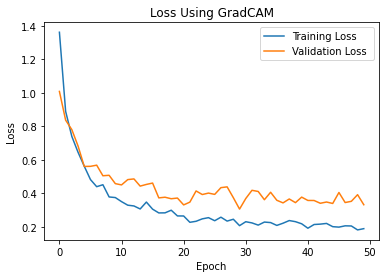

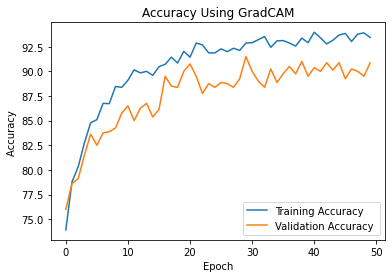

In [21]:
plt.rcParams["figure.figsize"] = (6,4)
plot_graph(model5_stats[0],model5_stats[2],epochs,"Loss ","gradcam fb")
plot_graph(model5_stats[1],model5_stats[3],epochs,"Accuracy ","gradcam fb")

In [0]:
model5 = ClassifierGenerator().cuda()
name = "alvaro_gradcam_fb.pth"
path = F"/content/drive/My Drive/Colab Notebooks/Alvaro/{name}"
model5.load_state_dict(torch.load(path))

<All keys matched successfully>

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app



Test loss: 0.4764 
Testing Accuracy: 699/800 (87%)
bag Class Accuracy: 36/40 (90.0%)
beer Class Accuracy: 34/40 (85.0%)
book Class Accuracy: 35/40 (87.5%)
case Class Accuracy: 32/40 (80.0%)
coffee Class Accuracy: 39/40 (97.5%)
cup Class Accuracy: 36/40 (90.0%)
deodorant Class Accuracy: 33/40 (82.5%)
eraser Class Accuracy: 34/40 (85.0%)
hole Class Accuracy: 38/40 (95.0%)
mouse Class Accuracy: 34/40 (85.0%)
mug Class Accuracy: 28/40 (70.0%)
sleep Class Accuracy: 36/40 (90.0%)
speaker Class Accuracy: 34/40 (85.0%)
spray Class Accuracy: 30/40 (75.0%)
stapler Class Accuracy: 36/40 (90.0%)
tape Class Accuracy: 35/40 (87.5%)
tea Class Accuracy: 38/40 (95.0%)
tissues Class Accuracy: 40/40 (100.0%)
umbrella Class Accuracy: 34/40 (85.0%)
watch Class Accuracy: 37/40 (92.5%)
Classifier has Acc=0.874 P=0.874 R=0.881 F1=0.875
              precision    recall  f1-score   support

         bag       0.86      0.90      0.88        40
        beer       0.87      0.85      0.86        40
        book

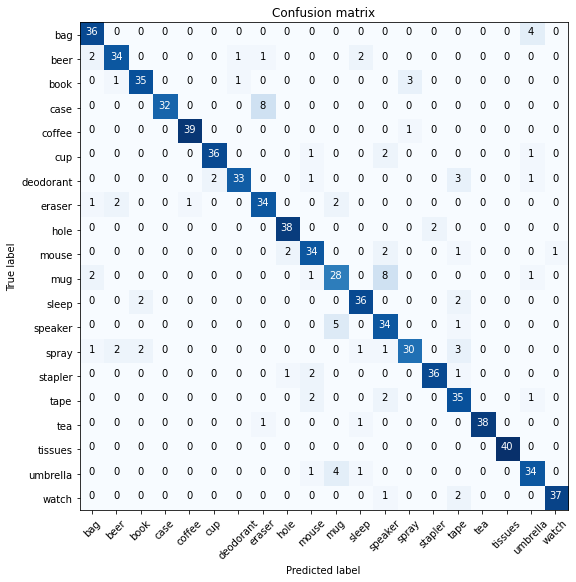

In [20]:
accuracies_model5 = test_model(model5,criterion,"gradcam fb")

[87.3798076923077, 86.0576923076923, 83.17307692307692, 81.1298076923077, 79.44711538461539]
/content/drive/My Drive/Colab Notebooks/Graphs/gradcam fb_Acc per iteration.png


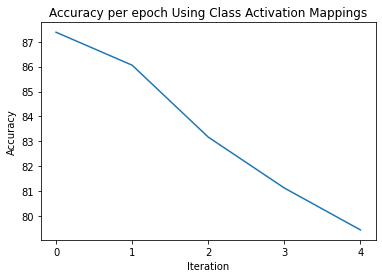

In [21]:
accuracy_per_iteration(accuracies_model5,"gradcam fb")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


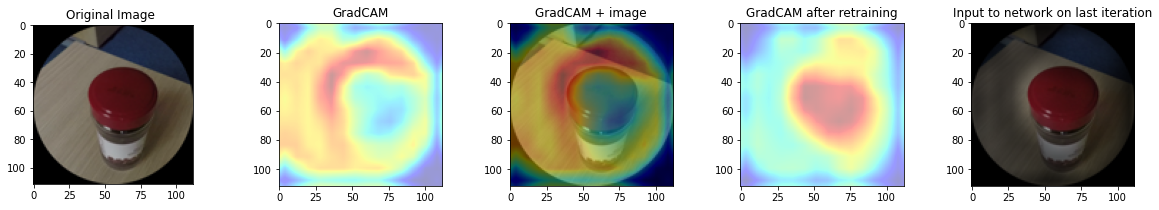

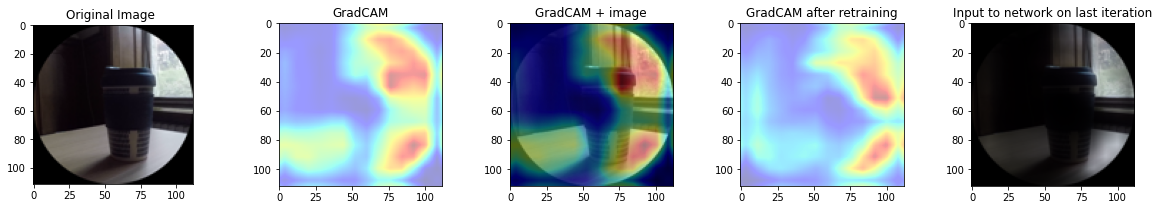

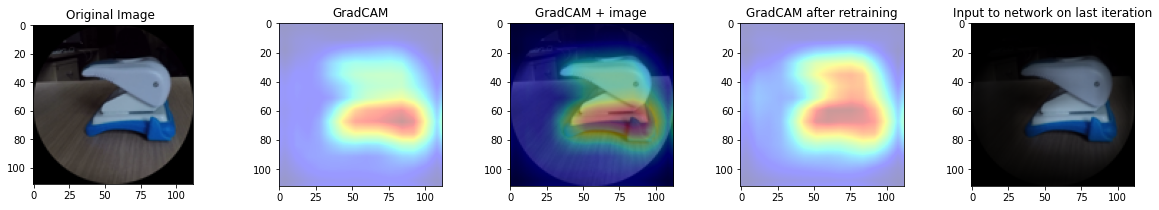

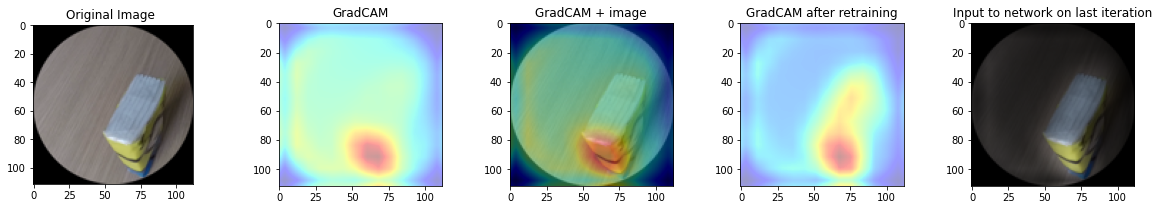

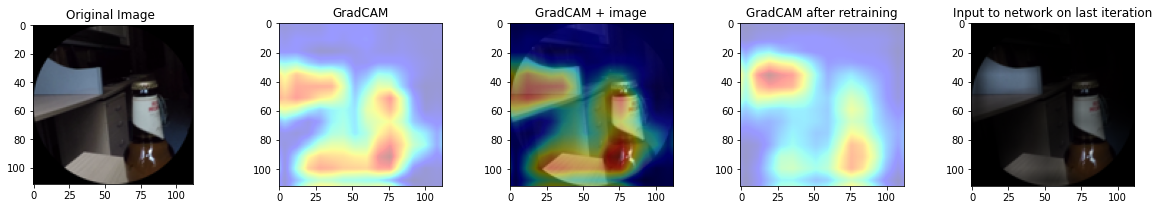

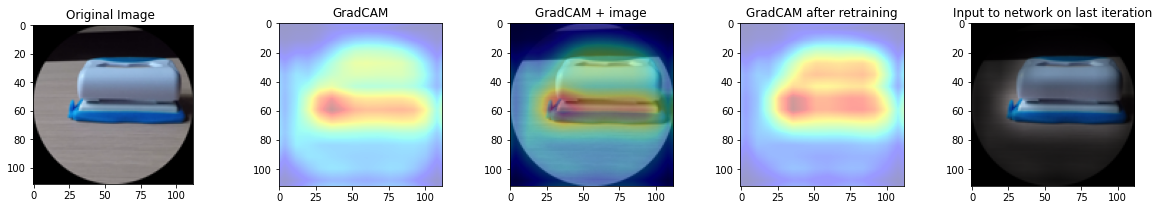

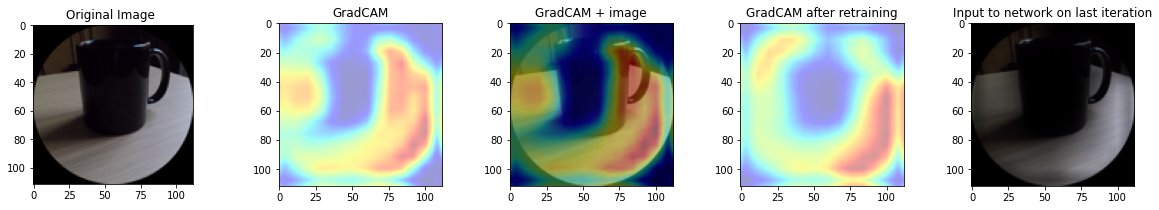

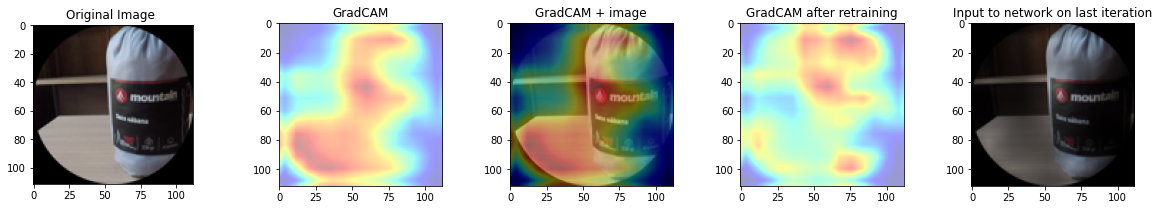

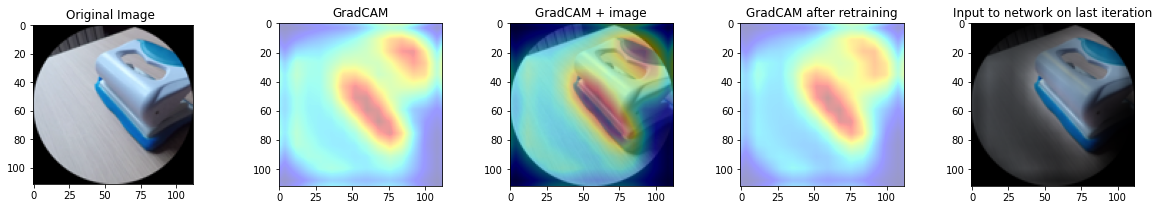

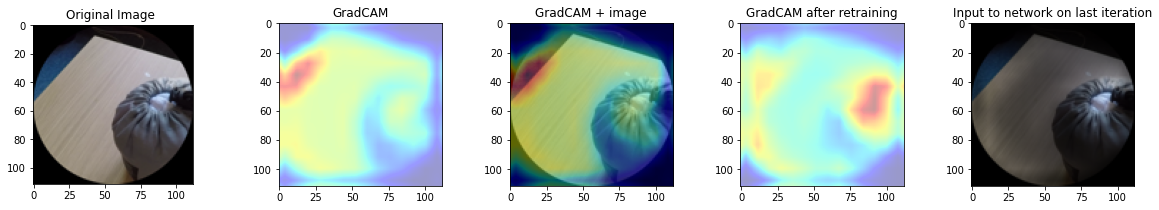

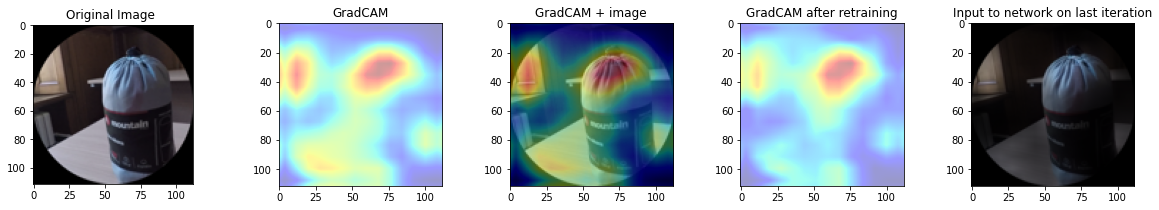

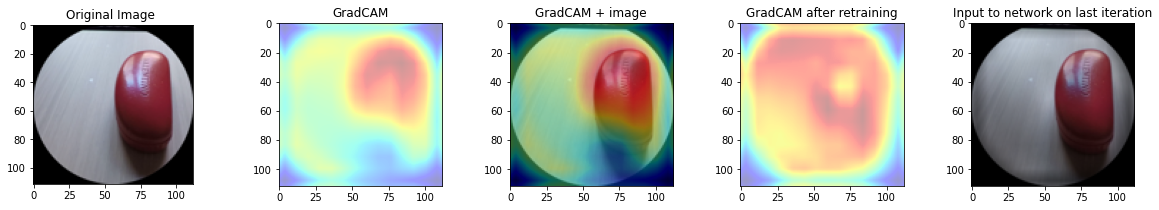

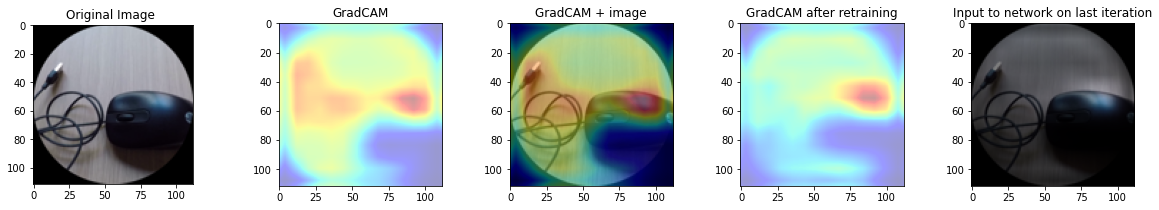

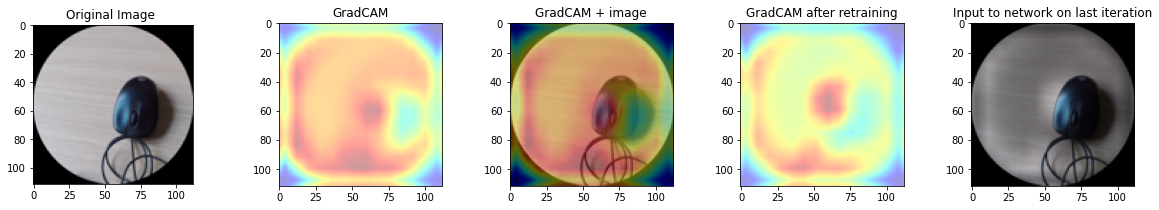

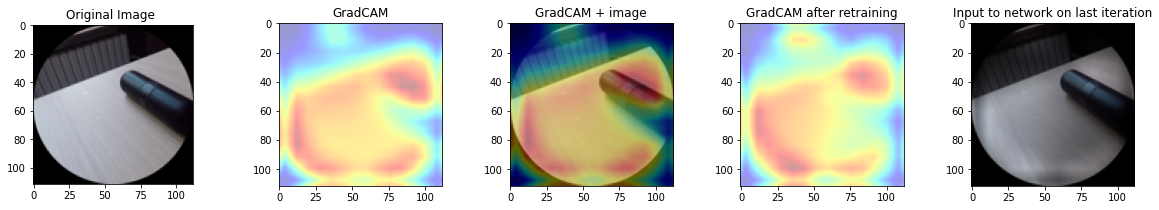

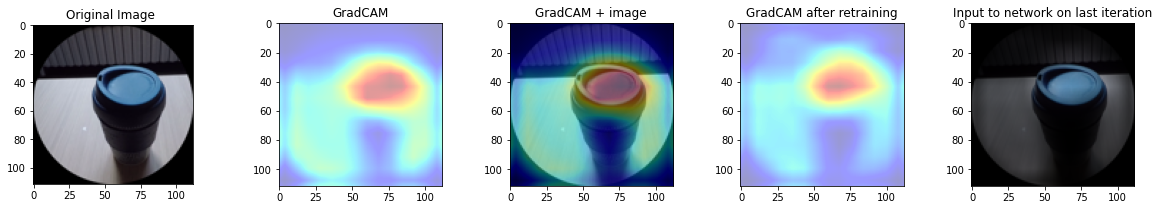

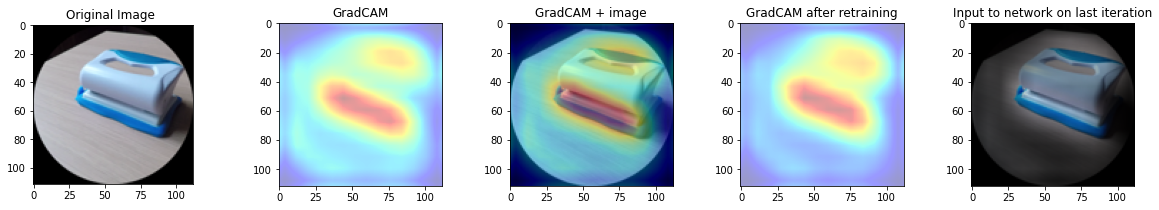

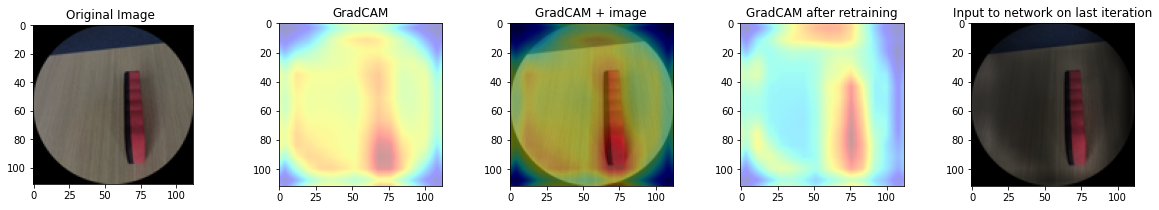

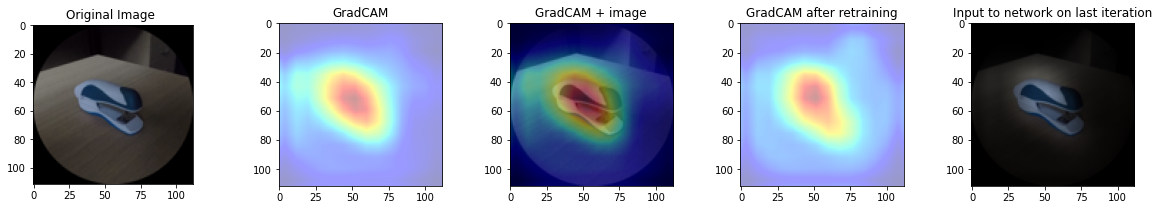

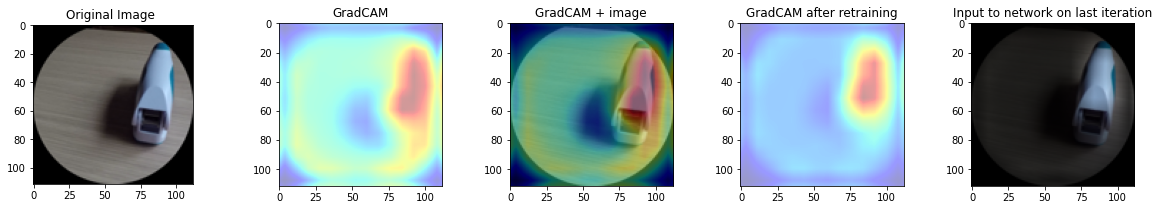

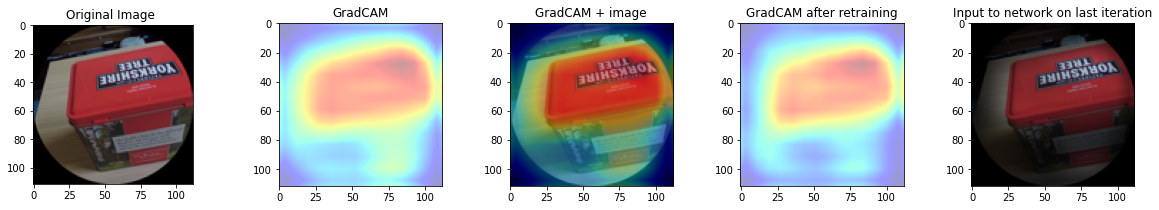

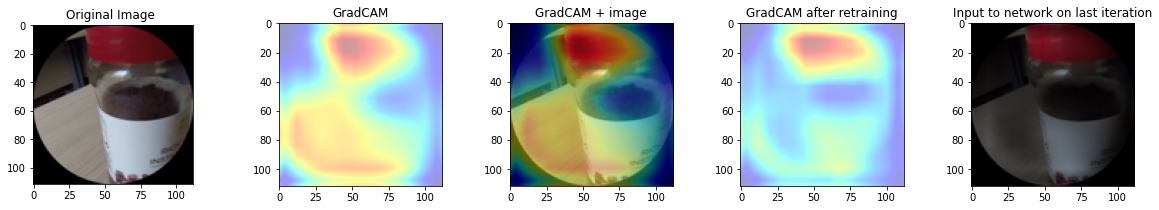

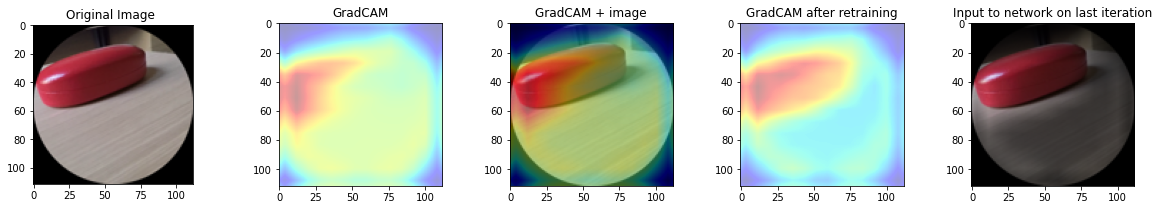

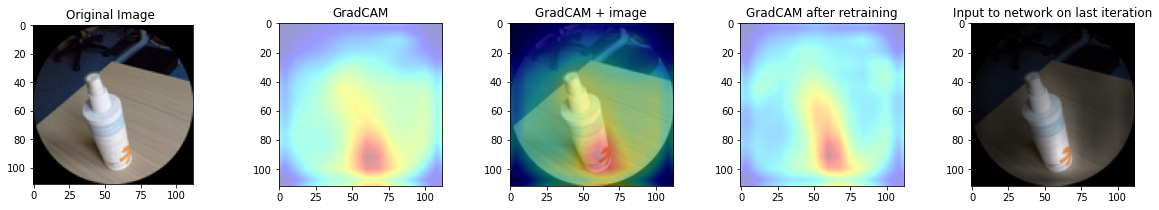

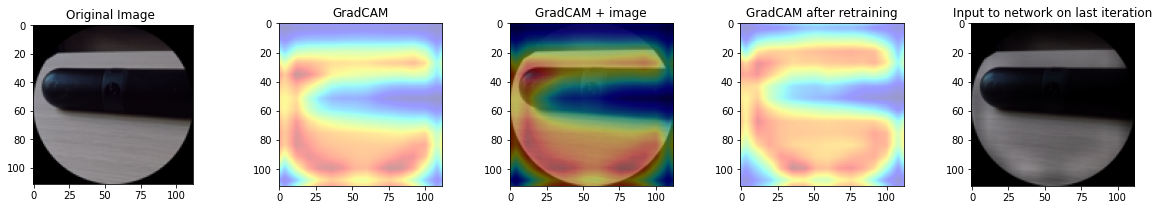

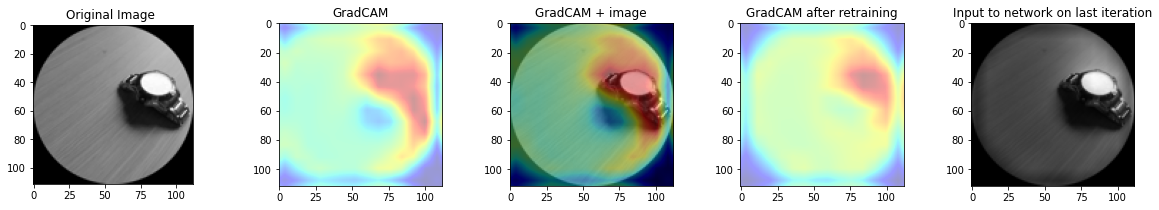

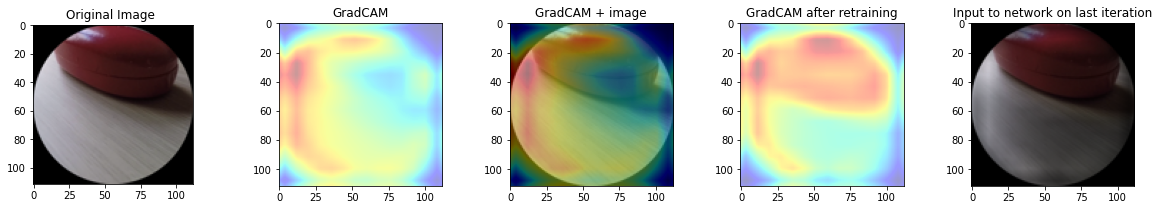

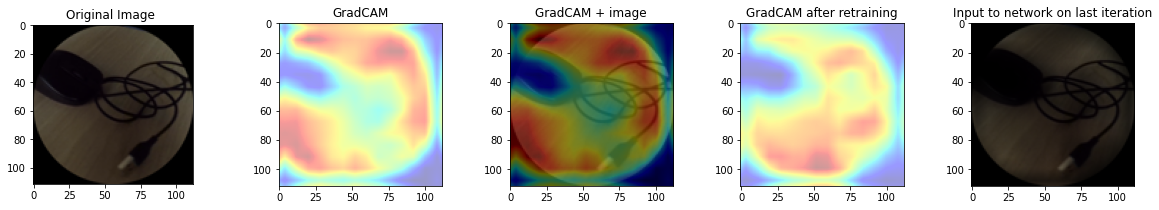

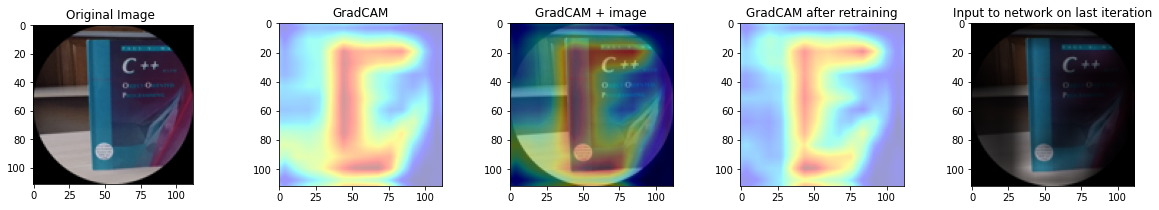

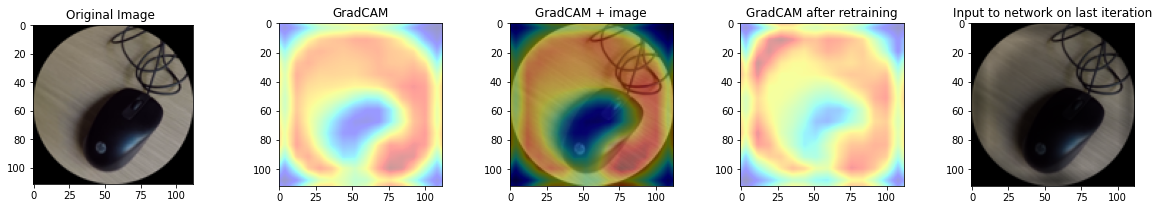

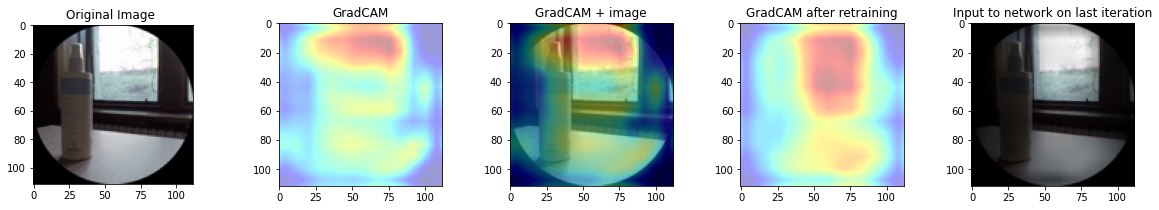

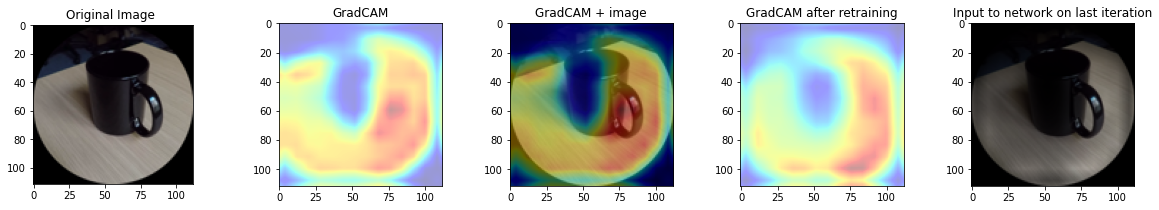

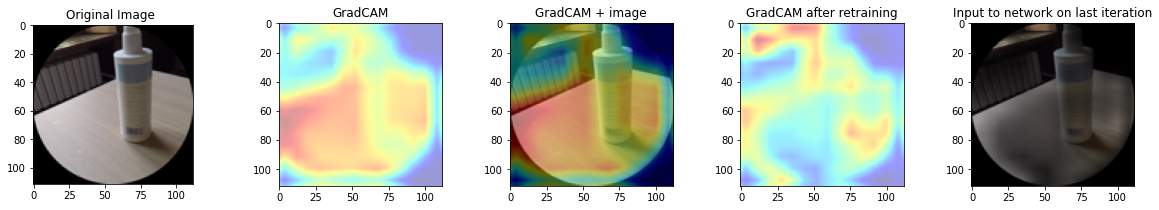

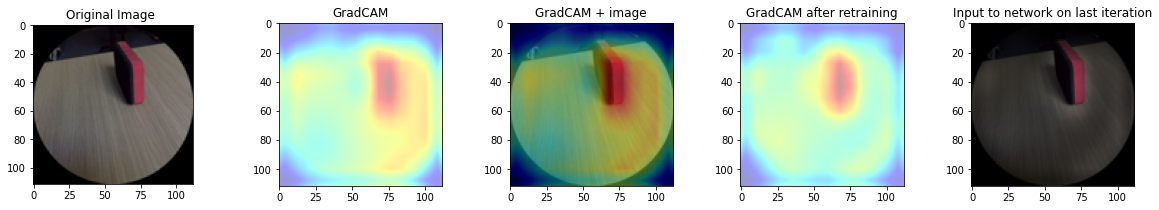

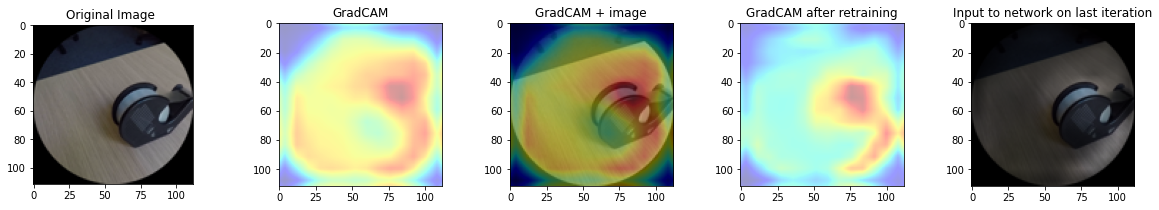

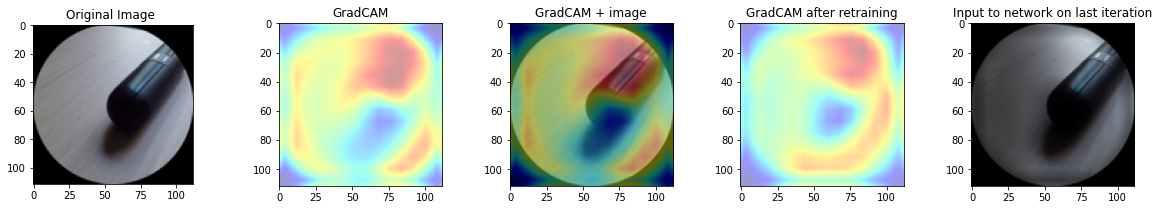

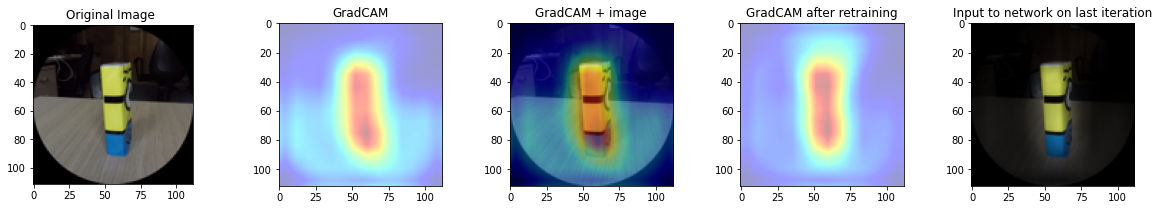

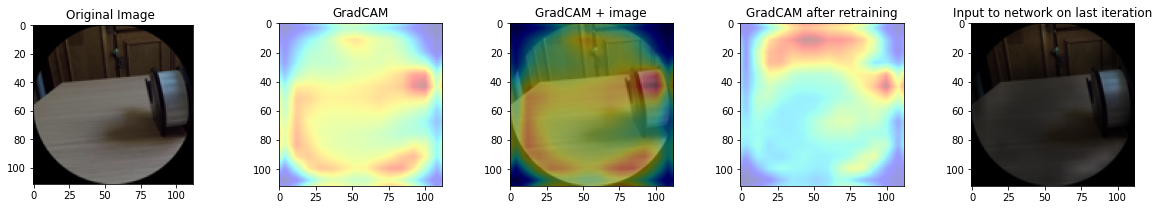

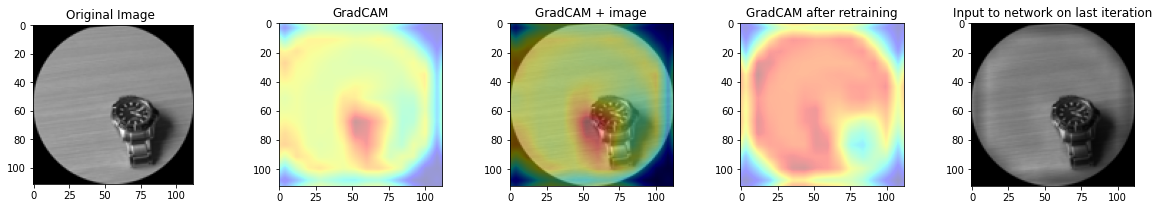

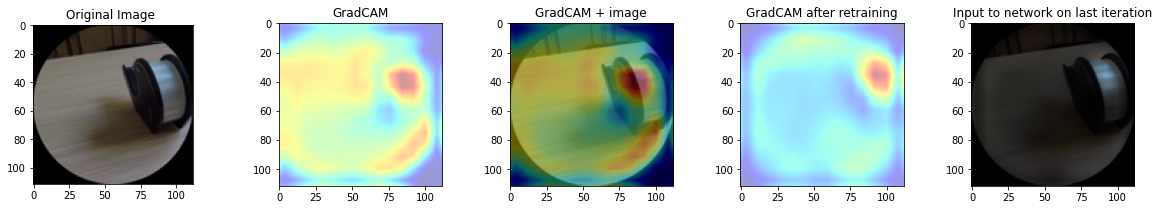

In [22]:
model5.eval()
model1.eval()
test_images, labels = next(iter(testloader))
test_images = test_images.cuda()
plt.rcParams["figure.figsize"] = (20,3)
for i in range(40):
  fig = plt.figure()
  image = test_images[i].cpu()
  plot = fig.add_subplot(1, 6, 1)
  plot.set_title('Original Image ')
  image_input = np.transpose(image,(1,2,0))
  imgplot = plt.imshow(image_input)

  plot = fig.add_subplot(1,5,2)
  plot.set_title("GradCAM")
  gradcam = generate_gradcam(image,model1,"conv4","fc3")
  #plt.imshow(image_input)
  plt.imshow(gradcam,alpha=0.4,cmap='jet')

  plot = fig.add_subplot(1,5,3)
  plot.set_title("GradCAM + image")
  plt.imshow(image_input)
  plt.imshow(gradcam,alpha=0.4,cmap='jet')

  #plot = fig.add_subplot(1,6,4)
  #plot.set_title("Input to network")
  #plt.imshow(np.transpose(image*gradcam,(1,2,0)))
  #plt.imshow(gradcam,alpha=0.4,cmap='jet')

  plot = fig.add_subplot(1,5,4)
  plot.set_title("GradCAM after retraining")
  gradcam = generate_gradcam(image,model5,"conv4","fc3")
  #plt.imshow(image_input)
  plt.imshow(gradcam,alpha=0.4,cmap='jet')

  plot = fig.add_subplot(1,5,5)
  plot.set_title("Input to network on last iteration")
  plt.imshow(np.transpose(image*gradcam,(1,2,0)))
  #plt.imshow(gradcam,alpha=0.4,cmap='jet')

# ResNet 112x112

In [0]:
model3 = models.resnet34(pretrained=True)
for param in model3.parameters():
    param.requires_grad = False
num_features = model3.fc.in_features
model3.fc = nn.Linear(num_features,20)
model3 = model3.cuda()
optimizer = optim.Adam(model3.fc.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss()
model3,model3_stats = train_validate(model3,optimizer,criterion,"plain")

Epoch 0
Average training loss: 1.8835, Training Accuracy: 1752/3200 (55%)
Average validation loss: 1.0085, Validation Accuracy: 672/800 (84%)
Epoch 1
Average training loss: 0.6744, Training Accuracy: 2891/3200 (90%)
Average validation loss: 0.5345, Validation Accuracy: 724/800 (90%)
Epoch 2
Average training loss: 0.4051, Training Accuracy: 3026/3200 (95%)
Average validation loss: 0.3764, Validation Accuracy: 753/800 (94%)
Epoch 3
Average training loss: 0.2915, Training Accuracy: 3081/3200 (96%)
Average validation loss: 0.2924, Validation Accuracy: 765/800 (96%)
Epoch 4
Average training loss: 0.2257, Training Accuracy: 3124/3200 (98%)
Average validation loss: 0.2394, Validation Accuracy: 770/800 (96%)
Epoch 5
Average training loss: 0.1814, Training Accuracy: 3142/3200 (98%)
Average validation loss: 0.2111, Validation Accuracy: 771/800 (96%)
Epoch 6
Average training loss: 0.1558, Training Accuracy: 3145/3200 (98%)
Average validation loss: 0.1859, Validation Accuracy: 770/800 (96%)
Epoch 

In [0]:
name = "alvaro_resnet_112x112.pth"
path = F"/content/drive/My Drive/Colab Notebooks/Alvaro/{name}"
torch.save(model3.state_dict(), path)

In [0]:
model2 = models.resnet34(pretrained=True).cuda()
name = "alvaro_resnet.pth"
path = F"/content/drive/My Drive/Colab Notebooks/Alvaro/{name}"
torch.save(model2.state_dict(), path)
#for param in model2.parameters():
    #param.requires_grad = False
#num_features = model2.fc.in_features
#model2.fc = nn.Linear(num_features,20)

In [0]:
model3 = models.resnet34(pretrained=True).cuda()
for param in model3.parameters():
    param.requires_grad = False
num_features = model3.fc.in_features
model3.fc = nn.Linear(num_features,20)
name = "alvaro_resnet_112x112.pth"
path = F"/content/drive/My Drive/Colab Notebooks/Alvaro/{name}"
model3.load_state_dict(torch.load(path))
model3 = model3.cuda()

In [0]:
test_images, labels = next(iter(testloader))
test_images = test_images.cuda()
plt.rcParams["figure.figsize"] = (20,3)
for i in range(15):
  fig = plt.figure()
  image = test_images[i].cpu()
  plot = fig.add_subplot(1, 3, 1)
  plot.set_title('Original Image ')
  image_input = np.transpose(image,(1,2,0))
  imgplot = plt.imshow(image_input)

  plot = fig.add_subplot(1,3,2)
  plot.set_title("GradCAM")
  gradcam = generate_gradcam(image,model3,"layer4","fc")
  gradcam_t = torch.Tensor(gradcam)
  plt.imshow(image_input)
  plt.imshow(gradcam,alpha=0.4,cmap='jet')

  plot = fig.add_subplot(1,3,3)
  plot.set_title("Difference")
  difference = np.transpose((image*gradcam),(1,2,0))
  plt.imshow(np.clip(difference,0,1))